In [1]:
import numpy as np
from numba import njit
from scipy.linalg import svd, qr, inv, pinv
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import theano


import theano.tensor as T
from theano.ifelse import ifelse
from theano.tensor.nlinalg import svd
from theano import function, shared
import arviz as az

c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\dominik\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pymc3 as pm
from pymc3.ode import DifferentialEquation


# path = r"C:\Users\dominik\Documents\Projects\Bilirubin\UV-Vis data"
path = r"C:\Users\Dominik\Documents\MUNI\Organic Photochemistry\Projects\2019-Bilirubin project\UV-VIS\QY measurement\Photodiode\new setup"


data_led = np.loadtxt(path + r'\LED sources.txt', delimiter='\t', skiprows=1)

LED_355 = data_led[:, 1] / np.trapz(data_led[:, 1])
LED_375 = data_led[:, 2] / np.trapz(data_led[:, 2])
LED_405 = data_led[:, 3] / np.trapz(data_led[:, 3])
LED_420 = data_led[:, 4] / np.trapz(data_led[:, 4])
LED_450 = data_led[:, 5] / np.trapz(data_led[:, 5])
LED_470 = data_led[:, 6] / np.trapz(data_led[:, 6])
LED_490 = data_led[:, 7] / np.trapz(data_led[:, 7])

In [3]:
# pythonic version
def _lstsq_D(C, D):
    U, S, VT = np.linalg.svd(C, full_matrices=False)

    Sr = S[S > S[0] * 1e-10]
    Ur = U[:, :Sr.shape[0]]

    CC_plus_D = Ur.dot(Ur.T).dot(D)

    return CC_plus_D

def Phi(phis, lambda_C=400, wavelengths=None):
    assert isinstance(phis, (list, np.ndarray))
    return sum(par * ((lambda_C - wavelengths) / 100) ** i for i, par in enumerate(phis))

# C, D = T.dmatrix('C'), T.dmatrix('D')

# # theano version
# U, S, VT = svd(C, full_matrices=0, compute_uv=1)

# Sr = S[S > S[0] * 1e-8]
# Ur = U[:, :Sr.shape[0]]
# CC_plus_D = Ur.dot(Ur.T).dot(D)

# _lstsq_D = function([C, D], CC_plus_D)



In [25]:
# eps = np.loadtxt(r'C:\Users\dominik\Documents\GitHub Repositories\Jupyter-Tutorials\Photoreaction kinetics\fit-A.csv',
#                  delimiter=',', skiprows=1)

eps = np.loadtxt(r'C:\Users\Dominik\Documents\MUNI\Organic Photochemistry\Projects\2019-Bilirubin project\UV-VIS\QY measurement\Photodiode\new setup\spectra_fit.csv',
                 delimiter=',', skiprows=1)
ST = eps[:, [1, 2]].T  # ST is a matrix of n x w
ST /= ST.max()

wavelengths = eps[:, 0] + 230
N = 100
times = np.linspace(0, 100, N)
# k = 0.05

# C = np.exp(-k * times[:, None])
# D = C @ ST[None, :]

# D = np.random.normal(D, 0.05)


phi = Phi([0.2], 400, wavelengths)
q0, V, c0 = 2e-1, 1, 1
I_source = LED_405

_0 = np.zeros(wavelengths.shape) if isinstance(phi, np.ndarray) else 0

K = np.asarray([[-phi,  _0],
                [+phi,  _0]])

K = np.transpose(K, (2, 0, 1))

const = np.log(10)
eps = ST


def dc_dt_py(c, t, p, _K):
    q0 = p[0] 
    c_eps = c[..., None] * eps  # hadamard product
    c_dot_eps = c_eps.sum(axis=0)
    
    x_abs = c_eps * np.where(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2,
                                     (1 - np.exp(-c_dot_eps * const)) / c_dot_eps) * I_source
    
    product = np.matmul(_K, x_abs.T[..., None])  # w x n x 1
    
    return q0 / V * np.trapz(product, axis=0).squeeze()
    

def dc_dt(c, t, p):
    q0 = p[0] 

    c_eps = c[..., None] * eps  # hadamard product
    
    c_dot_eps = c_eps.sum(axis=0)
    
#     x_abs = c_eps * T.switch(T.lt(c_dot_eps, 0.001), const - c_dot_eps * const * const / 2, 
#                    (1 - T.exp(-c_dot_eps * const)) / c_dot_eps) * I_source
    
    x_abs = c_eps * T.switch(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2, 
                   (1 - T.exp(-c_dot_eps * const)) / c_dot_eps) * I_source
    
#     n = x_abs.T[:, :, None]
    
    _product, _ = theano.scan(lambda a, b: T.dot(a, b), sequences=[K, x_abs.T[..., None]])
    
#     product = T.batched_dot(K, x_abs.T[..., None])

    return q0 / V * (_product.sum(axis=0) - (_product[0, ...] + _product[-1, ...]) / 2).squeeze()

#     x_abs = c_eps * np.where(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2, (1 - np.exp(-c_dot_eps * const)) / c_dot_eps) * I_source

#     # w x n x n   x   w x n x 1
#     product = np.matmul(K, x_abs.T[..., None])  # w x n x 1

#     return q0 / V * np.trapz(_product, axis=0).squeeze()


t_y = T.vector("y", dtype='float64')
t_t = T.scalar("t", dtype='float64')
t_p = T.vector("p", dtype='float64')
# K = T.tensor3("_K", dtype='float64')


_func_theano = dc_dt(t_y, t_t, t_p)
func = function([t_y, t_t, t_p], _func_theano, on_unused_input='warn')

# theano.config.blas.ldflags='-lmkl_rt'


# c = T.tensor3('a', dtype='float64')
# f = T.tensor3('b', dtype='float64')

# _product, _ = theano.scan(lambda a, b: T.dot(a, b), sequences=[c, f])

# _dot_func = function([c, f], _product)

# b = func([1, 0], 0, [1], K)
# b
# np.dot(K[0], b[50]).shape

# _dot_func(K, b).squeeze()

# np.matmul(K, func([1, 0], 0, [1])).squeeze().shape
# K
# K.shape, func([1, 0], 0, [1]).shape

# C = odeint(func, [c0, 0], times, args=((q0,), K))
# C_py = odeint(dc_dt_py, [c0, 0], times, args=((q0,), K))

# np.allclose(C, C_py, rtol=1e-8)


# C = odeint(func, [c0, 0], times, args=((q0,), K))

names = ['Z', 'E', 'HL', 'Unknown']

plt.rcParams['figure.figsize'] = [18, 10]
plt.subplot(2, 2, 1)
for i in range(K.shape[2]):
    plt.plot(times, C[:, i], label=names[i])
plt.plot(times, C.sum(axis=1), label='+'.join(names[0:2]), linestyle='--')
plt.xlabel('Time')
plt.ylabel('Concentration (M)')
plt.legend()

D = C @ ST  # compute data matrix
D_obs = np.random.normal(D, 0.01)


# plot time-dependent spectra
t = times.shape[0]
plt.subplot(2, 2, 2)
for i in reversed(range(0, t, 10)):
    plt.plot(wavelengths, D_obs[i], color=(1, i/t, 0, (t-i/1.4)/t), label='$t = {}$'.format(times[i]), lw=1)
plt.plot(wavelengths, D_obs.max() * I_source / I_source.max(), label='irrsource', linestyle='--', color='black', lw=0.8)
plt.title("Spectra")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')



TypeError: slice indices must be integers or None or have an __index__ method

In [23]:
ode_model = DifferentialEquation(
    func=dc_dt,
    times=times,
    n_states=2, n_theta=1,
    t0=0
)

with pm.Model() as model:
    
    # Define priors
    sigma = pm.HalfNormal("sigma", sd=2)
    
#     theta = Normal('beta', mu=0, sd=10, shape=2)
    
    _k = pm.Normal('_k', mu=0.07, sd=3)
#     a1 = pm.Normal('a1', mu=0.5, sd=1)
#     a2 = pm.Normal('a2', mu=0.1, sd=1)
#     a3 = pm.Normal('a3', mu=1, sd=10)
    C = T.exp(-_k * times[:, None])
    
    U, S, VT = svd(C, full_matrices=0, compute_uv=1)

    Sr = S[S > S[0] * 1e-8]
    Ur = U[:, :Sr.shape[0]]
    CC_plus_D = Ur.dot(Ur.T).dot(D)

    # Define likelihood
    likelihood = pm.Normal('y', mu=CC_plus_D , sd=sigma, observed=D)

#     # Inference!
#     prior = pm.sample_prior_predictive()
#     trace = pm.sample(5000, tune=1000, cores=6) # draw 3000 posterior samples using NUTS sampling
#     posterior_predictive = pm.sample_posterior_predictive(trace)

TypeError: slice indices must be integers or None or have an __index__ method

In [139]:
data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002350B16DA48>,
      dtype=object)

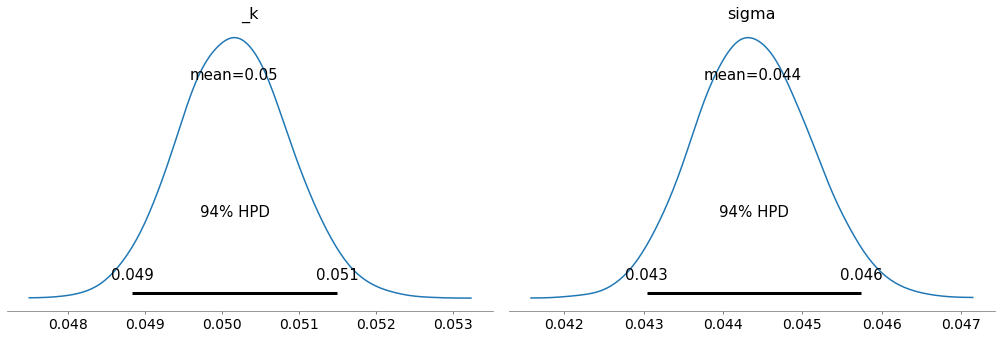

In [140]:
# pm.traceplot(trace[:])
az.plot_posterior(data)

In [126]:
from scipy.linalg import lstsq

trace["_k"].shape
k_samples = trace["_k"]

# k_samples.std()
Cs = np.exp(-k_samples * times[:, None])

STs = np.zeros((k_samples.shape[0], wls.shape[0]))

for i in range(k_samples.shape[0]):
    STs[i] = lstsq(Cs[:, i][:, None], D)[0]

# Cs[:, i].shape, D.shape

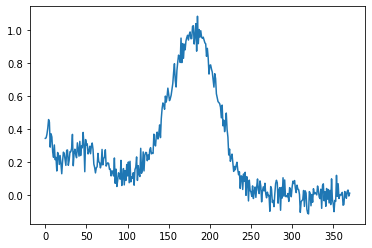

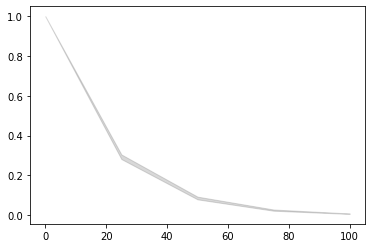

In [131]:
ST_avrg = STs.mean(axis=0)
Cs_avrg = Cs.mean(axis=1)

q_1, q_32, q_68, q_99 = np.quantile(STs, [0.01, 0.32, 0.68, 0.99], axis=0)
q_1, q_32, q_68, q_99 = np.quantile(Cs, [0.01, 0.32, 0.68, 0.99], axis=1)


plt.plot(wls,  ST_avrg)
# plt.fill_between(wls, q_1, q_99, color=(0.5, 0.5, 0.5, 0.3))

plt.show()

# plt.plot(times, Cs_avrg.squeeze())
plt.fill_between(times, q_1, q_99, color=(0.5, 0.5, 0.5, 0.3))

plt.show()


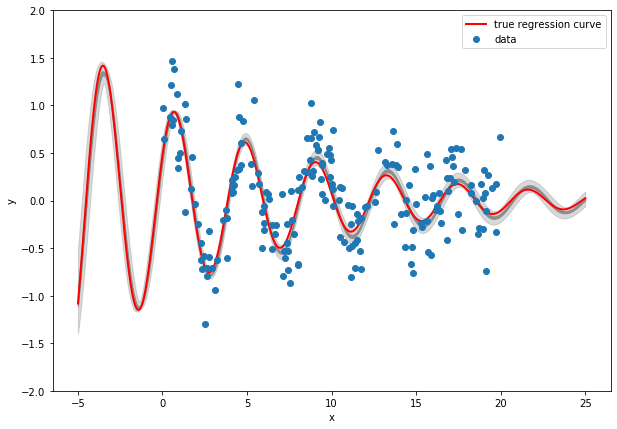

In [7]:
plt.figure(figsize=(10, 7))



# slope_samples = trace[100:]['slope']
# int_samples = trace[100:]['intercept']


# a0_samples = trace[100:]['a0']
# a1_samples = trace[100:]['a1']
# a2_samples = trace[100:]['a2']
# #a3_samples = trace[100:]['a3']


_x = np.linspace(-5, 25, 500)

# curves = a0_samples[:, None] + a1_samples[:, None] * _x[None, :] + a2_samples[:, None] * _x[None, :] ** 2#  + a3_samples[:, None] * _x[None, :] ** 3

curves = _model([a0_samples[:, None], a1_samples[:, None], a2_samples[:, None]], _x[None, :])


# lines = slope_samples[:, None] * _x[None, :] + int_samples[:, None]

# plt.plot(x, lines[::100].T, lw=0.1, color='gray')

true_y = _model(theta, _x)
plt.plot(_x, true_y, label='true regression curve', lw=2., c='r')

q_1, q_32, q_68, q_99 = np.quantile(curves, [0.01, 0.32, 0.68, 0.99], axis=0)


# slope_avrg = slope_samples.mean()
# int_avrg = int_samples.mean()
# line_avrg = slope_avrg  * _x + int_avrg

plt.fill_between(_x, q_32, q_68, color=(0.5, 0.5, 0.5, 0.8))
plt.fill_between(_x, q_1, q_99, color=(0.5, 0.5, 0.5, 0.3))

# plt.fill_between(_x, true_y + 2 * stds, true_y - 2 * stds, color=(0.5, 0.5, 0.5, 0.5))
# plt.fill_between(_x, true_y + 3 * stds, true_y - 3 * stds, color=(0.5, 0.5, 0.5, 0.3))

# plt.plot(_x, _model([a0_samples.mean(), a1_samples.mean(), a2_samples.mean()], _x), label='fit', lw=2., c='b')

plt.plot(x, y, 'o', label='data')



# plt.title('Posterior predictive regression lines')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 2)


plt.show()


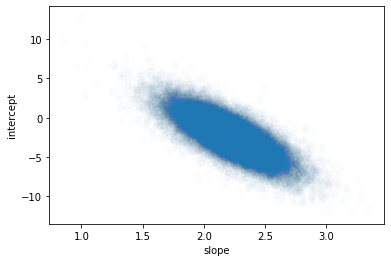

In [9]:
plt.plot(slope_samples[::1], int_samples[::1], 'o', alpha=0.01)
plt.xlabel('slope')
plt.ylabel('intercept')
plt.show()

In [86]:
samples = poisson_param.random(size=500000)

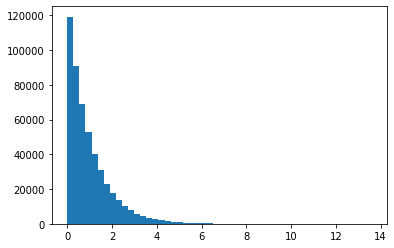

In [90]:
res = plt.hist(samples, bins=50, histtype="stepfilled")

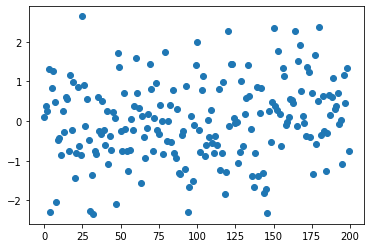

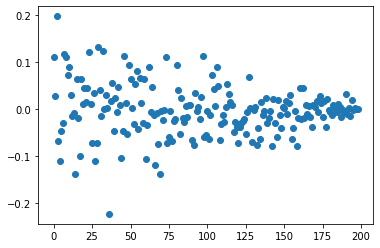

In [37]:
x = np.random.normal(0, 1, size=200)

corr =np.correlate(x, x, mode='full')
corr /= corr.max()
corr = corr[corr.size // 2 + 1:]

plt.plot(x, 'o')
plt.show()
plt.plot(corr, 'o')